# Download Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch

In [3]:
PATH = '/usr/local/data/titanic'

full = pd.read_csv('{}/train.csv'.format(PATH))
full.set_index('PassengerId', inplace=True)
full_copy = full.copy()

test = pd.read_csv('{}/test.csv'.format(PATH))
test.set_index('PassengerId', inplace=True)

# Create a Validation Set

In [4]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(full, test_size=0.2, random_state=99)

# Explore Data

In [5]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S
707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,NaN,S
133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 267 to 642
Data columns (total 11 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null object
Age         568 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Ticket      712 non-null object
Fare        712 non-null float64
Cabin       165 non-null object
Embarked    711 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [7]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,568.000000,712.000000,712.000000,712.000000
mean,0.387640,2.300562,29.400827,0.515449,0.372191,31.910738
std,0.487554,0.834960,14.286451,1.116196,0.795884,48.502809
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


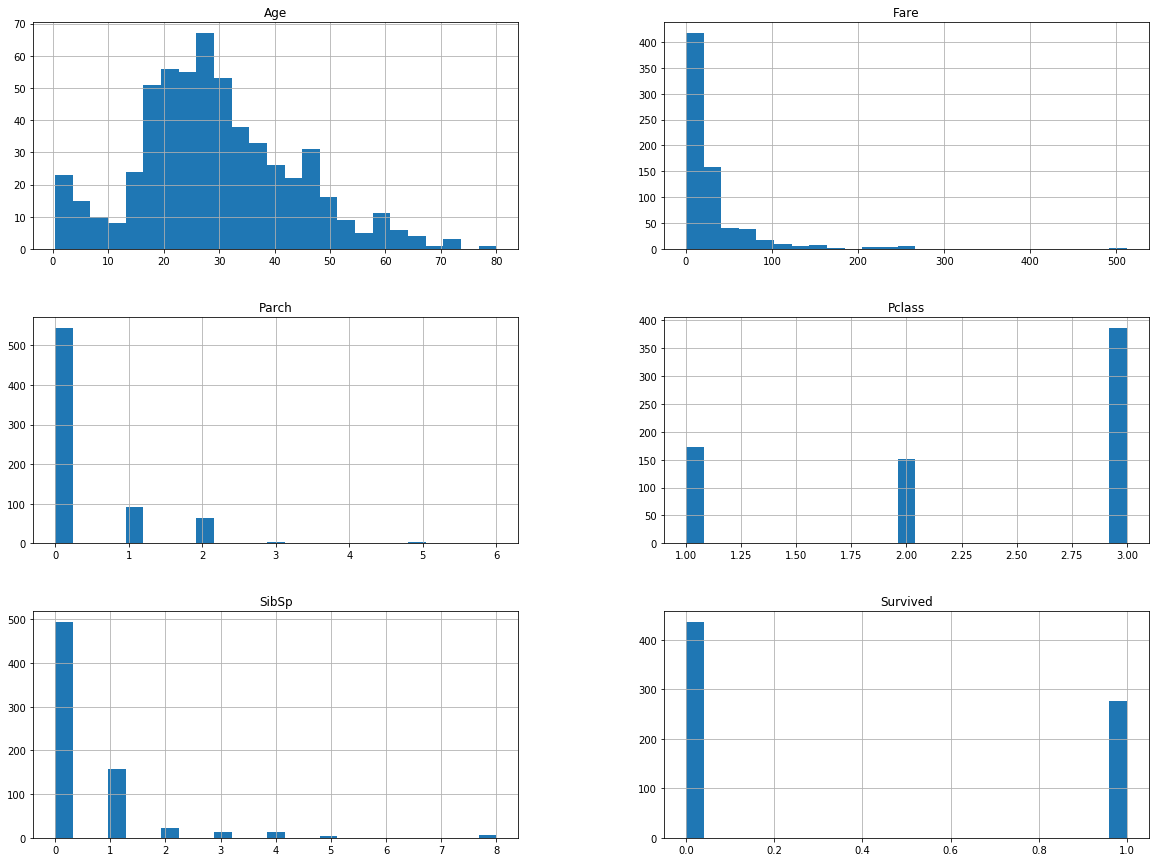

In [9]:
train.hist(bins=25, figsize=(20, 15))
plt.show()

In [10]:
corr_matrix = train.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.262389
Parch       0.098861
SibSp      -0.031696
Age        -0.085861
Pclass     -0.328065
Name: Survived, dtype: float64

# Submission Baseline

## Median Survival

In [31]:
submission = test.copy()
submission['Survived'] = full['Survived'].median()
submission.to_csv('{}/submission_000_median.csv'.format(PATH), columns=['Survived'], float_format='%.f')

## Median Survival by Gender

In [30]:
submission = test.copy()
survived_by_gender = full.groupby('Sex').Survived.median()
submission['Survived'] = submission['Sex'].map(survived_by_gender)
submission.to_csv('{}/submission_001_median_by_gender.csv'.format(PATH), columns=['Survived'], float_format='%.f')

# Engineer Features

In [514]:
def add_attributes(X, y=None):
    return X.assign(
        LastName=X.Name.str.split(',').str[0],
        CabinArea=X.Cabin.str[0],
        CabinCount=X.Cabin.str.split(' ').apply(lambda x: len(x) if isinstance(x, list) else 1.0),
        FamilyCount=X.SibSp + X.Parch + 1
    )

In [517]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, Imputer, StandardScaler
from ml.transformers import CategoricalEncoder, CategoricalImputer, DataFrameSelector

numeric_pipeline = Pipeline([
    ('adder', FunctionTransformer(add_attributes, validate=False)),
    ('selector', DataFrameSelector(['Age', 'Fare', 'FamilyCount'])),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler())
])

category_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Sex', 'Pclass', 'Embarked'])),
    ('imputer', CategoricalImputer(strategy='most_frequent')),
    ('encoder', CategoricalEncoder())
])

full_pipeline = FeatureUnion([
    ('numeric', numeric_pipeline),
    ('category', category_pipeline)
])

train_prepared = full_pipeline.fit_transform(train)
train_prepared

<712x11 sparse matrix of type '<class 'numpy.float64'>'
	with 4272 stored elements in Compressed Sparse Row format>

In [518]:
train_prepared_df = pd.SparseDataFrame(train_prepared)
train_prepared_df.info()
train_prepared_df.head().to_dense().fillna(0)

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
0     712 non-null float64
1     712 non-null float64
2     712 non-null float64
3     251 non-null float64
4     461 non-null float64
5     173 non-null float64
6     152 non-null float64
7     387 non-null float64
8     142 non-null float64
9     61 non-null float64
10    509 non-null float64
dtypes: float64(11)
memory usage: 33.5 KB


,0,1,2,3,4,5,6,7,8,9,10
0,-1.027905,0.160449,2.540916,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.949824,-0.121950,-0.548449,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.244572,-0.379848,-0.548449,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.401295,-0.359216,0.069424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.087570,-0.658378,-0.548449,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [510]:
reload(ml.transformers)

<module 'ml.transformers' from '/usr/local/lib/ml/transformers.py'>